In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

二、数据印象
2.1 数据构成分析

In [3]:
def get_titanic_data():
    train_data = pd.read_csv("/Users/yangmei/Downloads/7788/train.csv")
    test_data = pd.read_csv("/Users/yangmei/Downloads/7788/test.csv")
    return train_data, test_data

train_data, test_data = get_titanic_data()


In [4]:
print(train_data.shape)
print(test_data.shape)

(891, 12)
(418, 11)


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# 每列缺失值的比率

In [12]:
(train_data.shape[0] - train_data.count())/train_data.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

根据上面的数据，得到一些结论：

* 数据规模：采样偏差不大，训练规模较小。总共船员是2224人，死亡1502人，训练数据有891人，训练集死亡人数需要对比一下比例。数据条目m = 891, 有用特征数目n = 10（除去PassengerId字段）, 目标输出k = 1（Survived字段）。

* 数据特征：类型多样，需要进行筛选和处理。文本：Name；文本+数字：Ticket, Cabin；类目：Sex，Pclass，Embarked; 连续值：Age，Fare，SibSp，Parch。

* 数据质量：部分数据缺失严重，需要处理（拟合、填充或者参照组忽略）登陆港口少量缺失，年龄缺失1/4，客舱缺失3/4；异常值探测会在下面执行（比如某人的fare特别大等可以排查掉）。

In [8]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


2.2 数据统计学分析
根据数据特征分析，将训练数据进行划分：连续和离散，暂不分析包含文本字段。

In [9]:
target_column = 'Survived'
continuous_column_list = ['Age', 'SibSp', 'Fare',
                      'Parch']
discrete_column_list = ['Sex', 'Pclass', 'Embarked']
text_column_list = ['Name', 'Ticket', 'Cabin']

continuous_train_data = train_data.filter(continuous_column_list)
discrete_train_data = train_data.filter(discrete_column_list)

2.2.1 统计特征
2.2.1.1 连续值分析

In [10]:
continuous_train_data.describe()

,Age,SibSp,Fare,Parch
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,32.204208,0.381594
std,14.526497,1.102743,49.693429,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,7.910400,0.000000
50%,28.000000,0.000000,14.454200,0.000000
75%,38.000000,1.000000,31.000000,0.000000
max,80.000000,8.000000,512.329200,6.000000


总体情况
* 年龄：主要集中在15~40之间，根据四分区间可知分布较均匀，老人和小孩是少数，即skewed data，很可能被忽略，所以后期可以增加额外的特征字段；根据经验，年龄字段适合作为区间来处理。
* 票价：票价分配不均匀，均值在32，中值在14，方差波动大，少数人的票价较高，同样是skewed data，可以增加高价票字段。
* SibSp(旁系亲属)和Parch(直系亲属)：范围取值均在0~10以内，可以考虑作为类目字段处理。75%以上人的Parch都是0，可以考虑换成0/1，考虑结合后期的相关性分析来获得结果。

In [ ]:
#柱状图 Draw histogram of the DataFrame’s series using matplotlib / pylab.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117344358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11745c320>]], dtype=object)

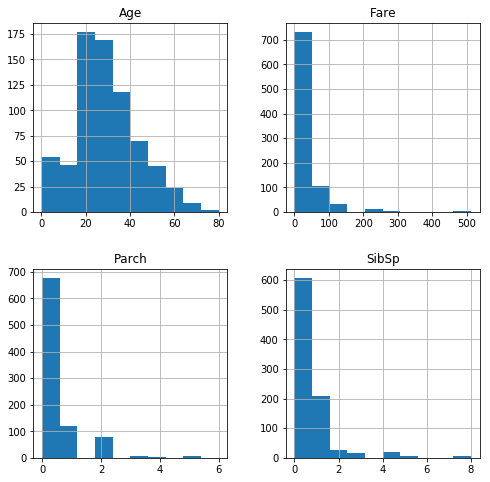

In [11]:
continuous_train_data.hist(figsize=(8, 8))

由柱状图可知：
Parch、SibSp取值少，分布不均匀，不适合作为连续值来处理；
Fare和Age部分区间取值过少，这部分特征容易被掩盖，需要提取额外的特征值。？？？

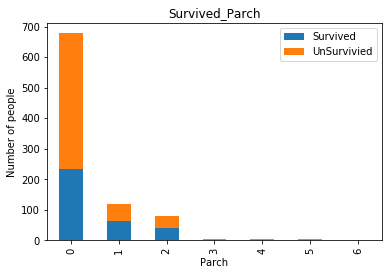

Parch
0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

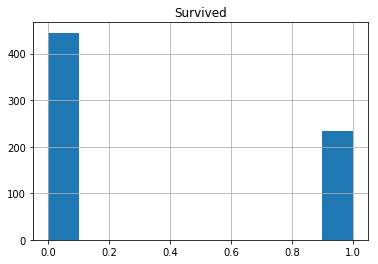

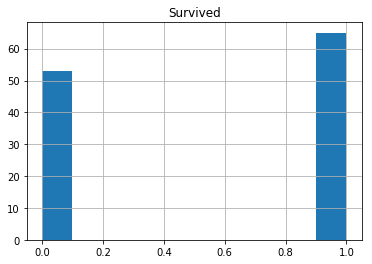

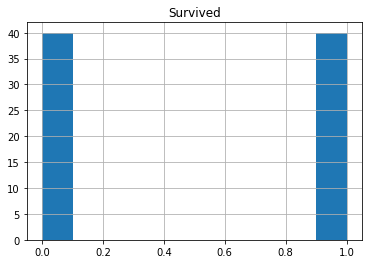

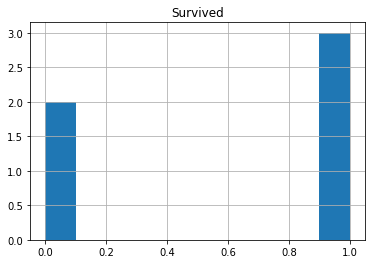

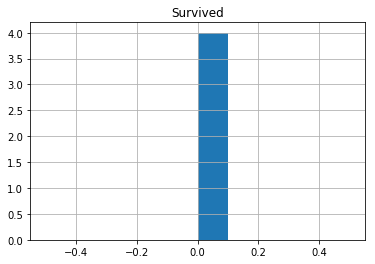

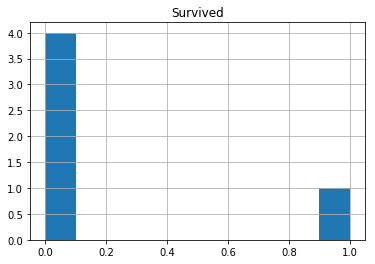

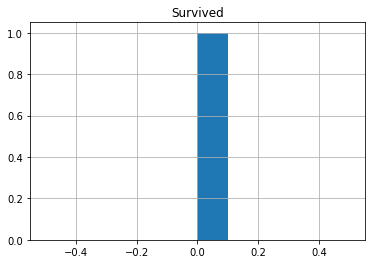

In [13]:
feature = 'Parch'
feature_data = train_data.filter([feature, 'Survived'])
survived_data = feature_data[feature][feature_data.Survived == 1].value_counts()
unsurvived_data = feature_data[feature][feature_data.Survived == 0].value_counts()
df = pd.DataFrame({'Survived': survived_data, 'UnSurvivied': unsurvived_data})
df.plot(kind='bar', stacked=True)
plt.title('Survived_' + feature)
plt.xlabel(feature)
plt.ylabel(u'Number of people')
plt.show()

feature_data.groupby(feature).hist() #???

### 相关性分析
二分类问题不适合皮尔逊相关系数，使用卡方校验检测Parch和SibSp和Survived相关性。

In [14]:
from scipy.stats import pearsonr
print("Parch:", pearsonr(train_data["Parch"], train_data['Survived']))
print("SibSp:", pearsonr(train_data["SibSp"], train_data['Survived']))
print("PassengerId:", pearsonr(train_data["PassengerId"], train_data['Survived']))

Parch: (0.081629407083483485, 0.0147992453747224)
SibSp: (-0.035322498885735583, 0.29224392869817906)
PassengerId: (-0.0050066607670664854, 0.88136577687981443)


In [16]:
from minepy import MINE
def mic(x, y):
    m = MINE()
    m.compute_score(x, y)
    return (m.mic(), 0.5)

print("Parch:", mic(train_data["Parch"], train_data['Survived']))
print("SibSp:", mic(train_data["SibSp"], train_data['Survived']))
print("PassengerId:", mic(train_data["PassengerId"], train_data['Survived']))

ModuleNotFoundError: No module named 'minepy'

In [17]:
from sklearn.feature_selection import chi2
print("Parch:", chi2(train_data.filter(["Parch"]), train_data['Survived']))
print("SibSp:", chi2(train_data.filter(["SibSp"]), train_data['Survived']))

Parch: (array([ 10.09749911]), array([ 0.00148471]))
SibSp: (array([ 2.58186538]), array([ 0.10809421]))


离散值分析¶

In [19]:
for column in discrete_train_data.columns:
    print(discrete_train_data[column].value_counts())#Returns object containing counts of unique values.

male      577
female    314
Name: Sex, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [32]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
sex_label_data = LabelBinarizer().fit_transform(train_data['Sex'])
embarked_label_data = LabelEncoder().fit_transform(train_data['Embarked'].fillna('S'))

print("Embarked", chi2(pd.DataFrame(embarked_label_data), train_data['Survived']))
print("Sex:", chi2(sex_label_data, train_data['Survived']))
print("Pclass:", chi2(train_data.filter(["Pclass"]), train_data['Survived']))

Embarked (array([ 10.20252466]), array([ 0.00140249]))
Sex: (array([ 92.70244698]), array([  6.07783826e-22]))
Pclass: (array([ 30.87369944]), array([  2.75378563e-08]))


由此可见：Sex以及Pclass的相关性特别强。Embarked需要进一步分析。

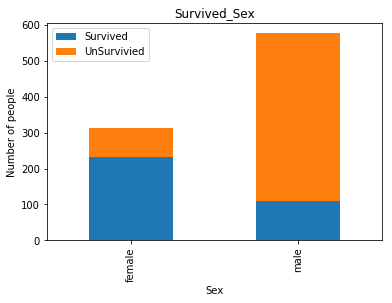

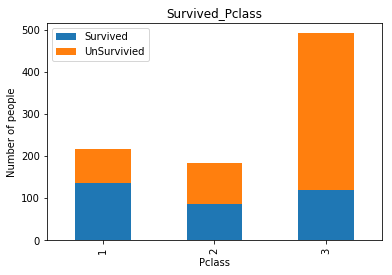

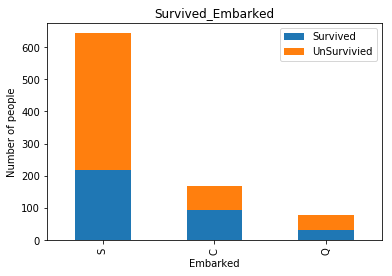

In [33]:
def print_stacked_hist(feature):
    feature_data = train_data.filter([feature, 'Survived'])
    survived_data = feature_data[feature][feature_data.Survived == 1].value_counts()
    unsurvived_data = feature_data[feature][feature_data.Survived == 0].value_counts()
    df = pd.DataFrame({'Survived': survived_data, 'UnSurvivied': unsurvived_data})
    df.plot(kind='bar', stacked=True)
    plt.title('Survived_' + feature)
    plt.xlabel(feature)
    plt.ylabel(u'Number of people')
    plt.show()

print_stacked_hist('Sex')
print_stacked_hist('Pclass')
print_stacked_hist('Embarked')

通过柱状图可知，女性和富人的存活率会更高。不同港口也存在差异，但是不是很明显。可以考虑去除。

### 三、数据预处理
3.1 基础操作
缺失值
缺失值处理方法：

拟合：缺失个数不多时，并且有背景特征可以使用时。
填充：缺失数据不多，而且数据可以离散化数据（连续数据考虑step为步长离散化），直接填充NaN新类型或者使用均值、中值。
0/1化：当是否有记录本身就有意义时，可以考虑将是否有数据作为一个特征。例如可能存在逃票等。
丢弃：缺失数据过多时为避免引入噪声，可以直接丢弃。
数据具体处理过程

* Age: 年龄缺失1/4，由于特征和年龄大多没有关系，采取Step(采用5年，由于数据量不大，避免过于分散)离散化+填充NaN新类型的方法。
* 客舱Cabin: 缺失3/4，因为船舱可能和身份有关，所以直接使用0/1化。
* 登录港口Embarked：登录港口缺失少量数据，直接填充为最常见类型。

In [166]:
def get_filled_data(train_data):    
    filled_data = train_data.copy()
    filled_data.loc[np.isnan(train_data['Age']), 'Age'] = 0
    def transform_category(data, start, step, category):
        """
        data是一个array数据
        """
        result = ((data - start) / step).astype(int) + category
        return result

    step = 5
    filled_data['Age'] = transform_category(filled_data['Age'], 0, step, 0)
    #------------
    filled_data.loc[filled_data['Cabin'].notnull(), 'Cabin'] = 1
    filled_data.loc[filled_data['Cabin'].isnull(), 'Cabin'] = 0
    #------------
    def get_most_common_category(series):
        return series.value_counts().axes[0][0]

    filled_data['Embarked'].value_counts()
    most_common = get_most_common_category(filled_data['Embarked'])
    filled_data.loc[filled_data['Embarked'].isnull(), 'Embarked'] = most_common
    return filled_data

filled_data = get_filled_data(train_data)
filled_test_data = get_filled_data(test_data)
filled_test_data.fillna(filled_test_data.mean(), inplace=True)

filled_data.info()
filled_test_data.info()


array([[ -4.98407056e-01],
       [ -5.13274288e-01],
       [ -4.65088464e-01],
       [ -4.83466313e-01],
       [ -4.18471482e-01],
       [ -4.73380908e-01],
       [ -5.01992978e-01],
       [ -1.18822896e-01],
       [ -5.09164821e-01],
       [ -2.05781498e-01],
       [ -4.97212944e-01],
       [ -1.72611722e-01],
       [  8.36228191e-01],
       [ -1.72611722e-01],
       [  4.58062263e-01],
       [ -1.41758452e-01],
       [ -4.17350881e-01],
       [ -5.09240126e-01],
       [ -4.96689400e-01],
       [ -5.09240126e-01],
       [  4.26237208e-01],
       [ -5.81930345e-01],
       [ -7.07123773e-02],
       [  4.61723489e-01],
       [  4.06549953e+00],
       [ -3.78802222e-01],
       [  4.72481255e-01],
       [ -5.09240126e-01],
       [ -9.19284833e-02],
       [ -2.50081976e-01],
       [ -1.72611722e-01],
       [ -7.39988746e-02],
       [ -2.69879850e-01],
       [ -2.18332225e-01],
       [  3.96653354e-01],
       [ -5.09164821e-01],
       [ -4.94448198e-01],
 

Dummy Coding
Sex、Cabin和Embarked进行dummy coding

In [167]:
def get_dummied_data(new_data):
    dummy_cabin = pd.get_dummies(new_data["Cabin"], prefix="Cabin")
    dummy_sex = pd.get_dummies(new_data['Sex'], prefix='Sex')
    dummy_embarked = pd.get_dummies(new_data['Embarked'], prefix='Embarked')

    dummied_data = pd.concat([new_data, dummy_cabin, dummy_sex, dummy_embarked], axis=1)
    dummied_data.drop(['Cabin', 'Sex', 'Embarked'], axis=1, inplace=True)
    return dummied_data

dummied_data = get_dummied_data(filled_data)
dummied_test_data = get_dummied_data(filled_test_data)

# dummied_data.head()

array([[ -4.98407056e-01],
       [ -5.13274288e-01],
       [ -4.65088464e-01],
       [ -4.83466313e-01],
       [ -4.18471482e-01],
       [ -4.73380908e-01],
       [ -5.01992978e-01],
       [ -1.18822896e-01],
       [ -5.09164821e-01],
       [ -2.05781498e-01],
       [ -4.97212944e-01],
       [ -1.72611722e-01],
       [  8.36228191e-01],
       [ -1.72611722e-01],
       [  4.58062263e-01],
       [ -1.41758452e-01],
       [ -4.17350881e-01],
       [ -5.09240126e-01],
       [ -4.96689400e-01],
       [ -5.09240126e-01],
       [  4.26237208e-01],
       [ -5.81930345e-01],
       [ -7.07123773e-02],
       [  4.61723489e-01],
       [  4.06549953e+00],
       [ -3.78802222e-01],
       [  4.72481255e-01],
       [ -5.09240126e-01],
       [ -9.19284833e-02],
       [ -2.50081976e-01],
       [ -1.72611722e-01],
       [ -7.39988746e-02],
       [ -2.69879850e-01],
       [ -2.18332225e-01],
       [  3.96653354e-01],
       [ -5.09164821e-01],
       [ -4.94448198e-01],
 

Feature Scaling
将fare数据归一化

In [171]:
from sklearn.preprocessing import StandardScaler
dummied_data['Fare'] = StandardScaler().fit_transform(dummied_data.filter(['Fare']))
dummied_test_data['Fare'] = StandardScaler().fit_transform(dummied_test_data.filter(['Fare']))
dummied_data['Fare'].describe()

count    8.910000e+02
mean    -4.373606e-17
std      1.000562e+00
min     -6.484217e-01
25%     -4.891482e-01
50%     -3.573909e-01
75%     -2.424635e-02
max      9.667167e+00
Name: Fare, dtype: float64

3.2 数据清洗
异常值处理主要用于非监督学习中，空间分布奇异点。
3.3 经验处理
Ticket和Name字段为文本字段，需要经验处理。
搜罗了一下一些博客。

Name中可以提取到性别信息Mrs、Mr，可以用于校验Sex正确性。
Name中有‘Capt’、‘Don'等可以作为Title字段
Ticket可以统计出类别，Titanic中类别过多，暂不使用。
综上，基础模型，暂时去除PassengerId、Ticket和Name字段

In [172]:
unsed_column = ['PassengerId', 'Name', 'Ticket']
target_prepared_y = dummied_data['Survived']
train_prepared_data = dummied_data.drop(unsed_column + ['Survived'], axis=1)

dummied_prepard_data = dummied_test_data.drop(unsed_column, axis=1)
train_prepared_data.info()
dummied_prepard_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Pclass        891 non-null int64
Age           891 non-null int64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Cabin_0       891 non-null uint8
Cabin_1       891 non-null uint8
Sex_female    891 non-null uint8
Sex_male      891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(1), int64(4), uint8(7)
memory usage: 41.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
Pclass        418 non-null int64
Age           418 non-null int64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          418 non-null float64
Cabin_0       418 non-null uint8
Cabin_1       418 non-null uint8
Sex_female    418 non-null uint8
Sex_male      418 non-null uint8
Embarked_C    418 non-null uint8

四、模型印象
先构建具有解释性的基础模型，例如LogisticRegression和DecisionTree。

LogisticRegression模型可以提供各特征的线性相关性分析。使用CV得到各特征的相关性如下。

In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import cross_validation, metrics
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    #alg.fit(X, Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, Y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(Y, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

特征学习

In [174]:
child_age = 15 / 5
old_man_age = 50 / 5

(train_data['Fare'] > 80).value_counts()
rich_fare = 1
def add_new_features(df):
    df['Child'] = df['Age'].apply(lambda x: 1 if 0 < x<= child_age else 0)
    df['Senior'] = df['Age'].apply(lambda x: 1 if x >= old_man_age else 0)
    df['Rich'] = df['Fare'].apply(lambda x: 1 if x >= rich_fare else 0)
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df['Single'] = df['Parch'].apply(lambda x: 1 if x == 0 else 0)
    return

add_new_features(train_prepared_data)
add_new_features(dummied_prepard_data)
dummied_prepard_data.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_0', 'Cabin_1',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Child', 'Senior', 'Rich', 'FamilySize', 'Single'],
      dtype='object')

特征选择
backward反向贪婪搜索

In [175]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
saved_list = ['Sex', 'Pclass']
def choose_feature_list(X, y, saved_list):
#     X=train_prepared_data
#     y=target_prepared_y
    left_columns = list(X.columns)
    lr = LogisticRegression()
    best_score = np.mean(cross_val_score(lr, X, y, cv=5))
    final_column_list = [x for x in left_columns]
    i=0
    while len(left_columns) >= 3:
        new_item = None
        print('best score:', best_score)

        for item in left_columns:
            i=i+1
            if item in saved_list:
                continue
            print(i)
            lr = LogisticRegression()
            new_column = [x for x in left_columns]
            new_column.remove(item)
            score = np.mean(cross_val_score(lr, X.filter(new_column), y, cv=5))
            print(score,'remove:',item,'rest:',len(new_column))
            if score > best_score:
                best_score = score
                new_item = item
                print('--change best')

        if new_item is None:
            break

        final_column_list.remove(item)
        print("remove:", new_item, "best_score ever", best_score)
        left_columns.remove(item)
        
choose_feature_list(train_prepared_data, target_prepared_y, saved_list)


best score: 0.785660902756
2
0.7845686926 remove: Age rest: 16
3
0.785660902756 remove: SibSp rest: 16
4
0.785660902756 remove: Parch rest: 16
5
0.787901816698 remove: Fare rest: 16
--change best
6
0.785660902756 remove: Cabin_0 rest: 16
7
0.786803400399 remove: Cabin_1 rest: 16
8
0.786784569189 remove: Sex_female rest: 16
9
0.785660902756 remove: Sex_male rest: 16
10
0.789025412203 remove: Embarked_C rest: 16
--change best
11
0.785660902756 remove: Embarked_Q rest: 16
12
0.786778221192 remove: Embarked_S rest: 16
13
0.789012858063 remove: Child rest: 16
14
0.789050662337 remove: Senior rest: 16
--change best
15
0.789031689273 remove: Rich rest: 16
16
0.785660902756 remove: FamilySize rest: 16
17
0.789019064206 remove: Single rest: 16
remove: Senior best_score ever 0.789050662337
best score: 0.789050662337
19
0.79127873843 remove: Age rest: 15
--change best
20
0.789019064206 remove: SibSp rest: 15
21
0.789019064206 remove: Parch rest: 15
22
0.787882772706 remove: Fare rest: 15
23
0.790

完全搜索

In [107]:
train_prepared_data.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_0', 'Cabin_1',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Child', 'Senior', 'Rich', 'FamilySize', 'Single'],
      dtype='object')

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import re
import itertools
drop_str = 'Age|SibSp|Parch|Cabin_*|Embarked_*|Senior|Rich|Single'
drop_list = [column for column in train_prepared_data.columns if re.match(drop_str, column)]
print(drop_list)
def choose_feature_list(X, y, drop_list):
#     X=train_prepared_data
#     y=target_prepared_y
    lr = LogisticRegression()
    best_score = np.mean(cross_val_score(lr, X, y, cv=5))
    final_drop_list = []
    cnt = 0
    for i in range(1, len(drop_list) + 1):
        drop = None
        for combination in itertools.combinations(drop_list, i):
    #         print(i,combination)
            cnt += 1
            new_train_X = X.drop(list(combination), axis=1)

            lr = LogisticRegression()
            score = np.mean(cross_val_score(lr, new_train_X, y, cv=5))

            if score > best_score:
                best_score = score
                final_drop_list = combination
                drop = True

            if cnt % 100 == 0:
                print(cnt )
        if drop:
            print("drop_list:", final_drop_list, "best_score ever", best_score)

choose_feature_list(train_prepared_data, target_prepared_y, drop_list)

['Age', 'SibSp', 'Parch', 'Cabin_0', 'Cabin_1', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Senior', 'Rich', 'Single']
drop_list: ('Senior',) best_score ever 0.789050662337
drop_list: ('Age', 'Single') best_score ever 0.79127873843
100
200
drop_list: ('Senior', 'Rich', 'Single') best_score ever 0.79352621315
300
400
500
drop_list: ('SibSp', 'Parch', 'Embarked_C', 'Senior') best_score ever 0.796878168457
600
700
800
900
1000
drop_list: ('Age', 'SibSp', 'Parch', 'Rich', 'Single') best_score ever 0.799150325893
1100
1200
1300
1400
1500
1600
1700
1800
drop_list: ('Age', 'SibSp', 'Parch', 'Cabin_0', 'Senior', 'Rich', 'Single') best_score ever 0.800267715257
1900
2000


In [113]:
remove_feature_list = ['Age', 'SibSp', 'Parch', 'Cabin_0', 'Senior', 'Rich', 'Single']
train_prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
Pclass        891 non-null int64
Age           891 non-null int64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Cabin_0       891 non-null uint8
Cabin_1       891 non-null uint8
Sex_female    891 non-null uint8
Sex_male      891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
Child         891 non-null int64
Senior        891 non-null int64
Rich          891 non-null int64
FamilySize    891 non-null int64
Single        891 non-null int64
dtypes: float64(1), int64(9), uint8(7)
memory usage: 75.8 KB


构建基础模型

0.865168539326
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Model Report
Accuracy : 0.807
AUC Score (Train): 0.845812
CV Score : Mean - 0.8381034 | Std - 0.01683666 | Min - 0.8062582 | Max - 0.8542112
[[-0.60151551  0.06636142  0.67510991  1.65894194 -0.95359784  0.43666837
   0.29259315 -0.02391742  0.1455331  -0.16704172]] ---- [-0.60151551  0.06636142  0.67510991  1.65894194 -0.95359784  0.43666837
  0.29259315 -0.02391742  0.1455331  -0.16704172]


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

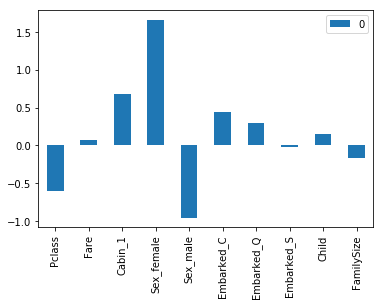

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import cross_validation, metrics

# new_prepared = train_prepared_data.drop(remove_feature_list, axis=1)
# X=new_prepared
# y=target_prepared_y
# model_class = LogisticRegression
# print_coef=True

def train_model(X, y, model_class, print_coef=False, *args, **kwargs):
    kf = KFold(n_splits=10)
    best_lr = None
    best_score = 0
    for train_index, test_index in kf.split(X):
        train_sub_data, target_sub_data = X.loc[train_index], y.loc[train_index]
        test_sub_data, test_target_sub_data = X.loc[test_index], y.loc[test_index]
        lr = model_class()
        lr.fit(train_sub_data, target_sub_data)
        score = lr.score(test_sub_data, test_target_sub_data)
        if score > best_score:
            best_lr = lr
            best_score = score
            
    print(best_score)
    print(best_lr)
    
#     printFeatureImportance=False
#     alg=best_lr
#     performCV=True
#     cv_folds=5
    def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
        #Fit the algorithm on the data
        #alg.fit(X, Y)
        
        #Predict training set:
        dtrain_predictions = alg.predict(X)
        dtrain_predprob = alg.predict_proba(X)[:,1]
        # alg.classes_ ==>array([0, 1])

        #Perform cross-validation:
        if performCV:
            cv_score = cross_validation.cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
        #Print model report:
        print("\nModel Report")
        print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
        print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))  

        if performCV:
            print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

        #Print Feature Importance:
        if printFeatureImportance:
            feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
            feat_imp.plot(kind='bar', title='Feature Importances')
            plt.ylabel('Feature Importance Score')
        
    modelfit(best_lr, X, y, printFeatureImportance=False)    
    if print_coef:
        columns = list(X.columns)
        print(best_lr.coef_,'----',best_lr.coef_.ravel())
        plot_df = pd.DataFrame(best_lr.coef_.ravel(), index=columns)
        plot_df.plot(kind='bar')

    return best_lr

new_prepared = train_prepared_data.drop(remove_feature_list, axis=1)
lr = train_model(new_prepared, target_prepared_y, LogisticRegression, print_coef=True)
lr

Learning curve

In [183]:
drop_data = dummied_prepard_data.drop(remove_feature_list, axis=1)
result = lr.predict(drop_data)
def print_result(passage_list, result):
    for i, key in passage_list.iteritems():
        print("{0},{1}".format(key, int(result[i])))

passage_list = test_data['PassengerId']
print_result(passage_list, result)        

892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,1
911,1
912,0
913,0
914,1
915,0
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,1
925,1
926,1
927,0
928,1
929,1
930,0
931,0
932,0
933,0
934,0
935,1
936,1
937,0
938,1
939,0
940,1
941,1
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,1
959,0
960,1
961,1
962,1
963,0
964,1
965,1
966,1
967,1
968,0
969,1
970,0
971,1
972,0
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,0
982,1
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,1
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,0
1009,1
1010,1
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,1
1024,0
1025,0
1026,0
1027,0
1028,0
1029,0
1030,1
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,0
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,1
1046,0
1047,0
1048,1
1049,1
10